# Unsupervised Pixel–Level Domain Adaptation with Generative Adversarial Networks

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
from torchinfo import summary
import pickle
import random
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os
from tqdm import tqdm
import json

In [2]:
base_path = "/content/drive/MyDrive/Colab Notebooks/HW6"
device = "cuda" if torch.cuda.is_available() else "cpu"

## Preprocessing Datasets

In [ ]:
zip_path = os.path.join(base_path, "dataset.zip")
extract_path = os.path.join(base_path, "dataset")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
extract_path = os.path.join(base_path, "dataset")
mnist_path = os.path.join(extract_path, "mnist.pkl")
mnist_m_path = os.path.join(extract_path, "mnistm.pkl")
with open(mnist_path, 'rb') as f:
    mnist_data = pickle.load(f)

with open(mnist_m_path, 'rb') as f:
    mnist_m_data = pickle.load(f)

In [ ]:
source_images = mnist_data[b'images']
source_labels = mnist_data[b'labels']
target_images = mnist_m_data[b'images']
target_labels = mnist_m_data[b'labels']

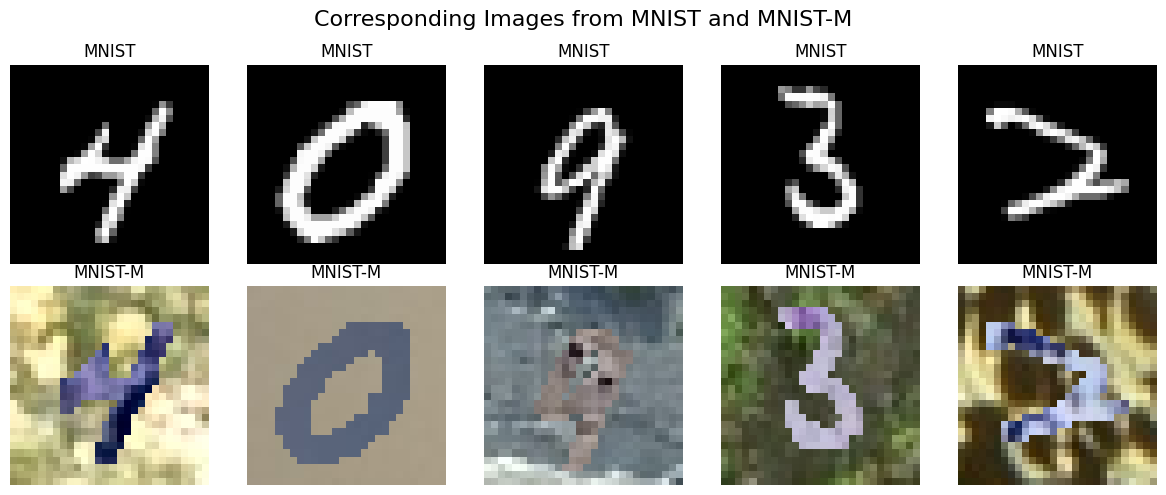

In [ ]:
num_images_to_plot = 5
num_available_images = len(source_images)
random_indices = random.sample(range(num_available_images), num_images_to_plot)

fig, axes = plt.subplots(2, num_images_to_plot, figsize=(12, 5))
fig.suptitle('Corresponding Images from MNIST and MNIST-M', fontsize=16)

for i, idx in enumerate(random_indices):
    mnist_img = source_images[idx]
    axes[0, i].imshow(mnist_img, cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title('MNIST')

    mnist_m_img = target_images[idx]
    axes[1, i].imshow(mnist_m_img)
    axes[1, i].axis('off')
    axes[1, i].set_title('MNIST-M')

plt.tight_layout()
plt.show()

In [11]:
IMG_SIZE = 32
BATCH_SIZE = 32
TRAIN_RATIO = 0.8

In [ ]:
num_samples = len(source_images)
indices = list(range(num_samples))
random.shuffle(indices)

split_point = int(np.floor(TRAIN_RATIO * num_samples))

train_indices = indices[:split_point]
test_indices = indices[split_point:]

print(f"Number of train images: {len(train_indices)}")
print(f"Number of test images: {len(test_indices)}")

Number of train images: 56000
Number of test images: 14000


In [ ]:
source_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

target_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

In [ ]:
source_dataset = CustomDataset(source_images, source_labels, transform=source_transform)
target_dataset = CustomDataset(target_images, target_labels, transform=target_transform)

In [ ]:
# Spliting datasets
source_train_dataset = Subset(source_dataset, train_indices)
source_test_dataset = Subset(source_dataset, test_indices)

target_train_dataset = Subset(target_dataset, train_indices)
target_test_dataset = Subset(target_dataset, test_indices)

In [ ]:
source_train_loader = DataLoader(source_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
target_train_loader = DataLoader(target_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

source_test_loader = DataLoader(source_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
target_test_loader = DataLoader(target_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Number of batches in MNIST-Train: {len(source_train_loader)}")
print(f"Number of batches in MNIST-Test: {len(source_test_loader)}")
print(f"Number of batches in MNIST-M-Train: {len(target_train_loader)}")
print(f"Number of batches in MNIST-M-Test: {len(target_test_loader)}")

Number of batches in MNIST-Train: 1750
Number of batches in MNIST-Test: 438
Number of batches in MNIST-M-Train: 1750
Number of batches in MNIST-M-Test: 438


In [ ]:
source_batch_img, _ = next(iter(source_train_loader))
target_batch_img, _ = next(iter(target_train_loader))
print(f"Tensor shape of source_train_loader: {source_batch_img.shape}")
print(f"Tensor shape of traget_train_loader: {target_batch_img.shape}")
print(f"Pixel's value range (source): [{source_batch_img.min():.2f}, {source_batch_img.max():.2f}]")
print(f"Pixel's value range (target): [{target_batch_img.min():.2f}, {target_batch_img.max():.2f}]")

Tensor shape of source_train_loader: torch.Size([32, 3, 32, 32])
Tensor shape of traget_train_loader: torch.Size([32, 3, 32, 32])
Pixel's value range (source): [-1.00, 1.00]
Pixel's value range (target): [-1.00, 1.00]


## Train base classifier and observing domain gap

In [3]:
class TaskClassifier(nn.Module):
    def __init__(self):
        super(TaskClassifier, self).__init__()

        self.private_part = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.shared_part = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=48, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc_part = nn.Sequential(
            nn.Linear(48 * 8 * 8, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10)
        )

    def forward(self, x):
        x = self.private_part(x)
        x = self.shared_part(x)
        x = x.view(x.size(0), -1)
        x = self.fc_part(x)
        return x

In [ ]:
def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.normal_(m.weight, mean=0.0, std=0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)

In [ ]:
def evaluate(model, dataloader, criterion, device):

    model.eval()
    total_loss, correct_preds, total_samples = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_preds += (predicted == labels).sum().item()
    return total_loss / total_samples, (correct_preds / total_samples) * 100

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, save_path):

    ### Learning rate decay
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20000, gamma=0.95)

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_accuracy = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step() ##
            running_loss += loss.item() * images.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        _, epoch_train_acc = evaluate(model, train_loader, criterion, device)
        epoch_val_loss, epoch_val_acc = evaluate(model, val_loader, criterion, device)

        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}% | "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")

        if epoch_val_acc > best_accuracy:
            best_accuracy = epoch_val_acc
            torch.save(model.state_dict(), save_path)

    model.load_state_dict(torch.load(save_path))
    return model, history

In [ ]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    ax1.plot(history['train_loss'], label='Train Loss', color='blue')
    ax1.plot(history['val_loss'], label='Validation Loss', color='orange')
    ax1.set_title('Loss over Epochs', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.legend()
    ax1.grid(True)

    ax2.plot(history['train_acc'], label='Train Accuracy', color='blue')
    ax2.plot(history['val_acc'], label='Validation Accuracy', color='orange')
    ax2.set_title('Accuracy over Epochs', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
ADAM_BETA1 = 0.5
NUM_EPOCHS = 20

In [ ]:
task_classifier_model = TaskClassifier().to(device)
task_classifier_model.apply(init_weights)

full_target_dataset = ConcatDataset([target_train_dataset, target_test_dataset])
target_full_loader = DataLoader(full_target_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    task_classifier_model.parameters(),
    lr=LEARNING_RATE,
    betas=(ADAM_BETA1, 0.999),
    weight_decay=WEIGHT_DECAY
)
MODEL_SAVE_PATH = os.path.join(base_path, "Best_Classifier_model.pth")

In [ ]:
input_shape = (3, 32, 32)
summary(task_classifier_model, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           2,432
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 48, 16, 16]          38,448
              ReLU-5           [-1, 48, 16, 16]               0
         MaxPool2d-6             [-1, 48, 8, 8]               0
            Linear-7                  [-1, 100]         307,300
              ReLU-8                  [-1, 100]               0
            Linear-9                  [-1, 100]          10,100
             ReLU-10                  [-1, 100]               0
           Linear-11                   [-1, 10]           1,010
Total params: 359,290
Trainable params: 359,290
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/

In [ ]:
best_classifier_model, history = train_model(
    model=task_classifier_model,
    train_loader=source_train_loader,
    val_loader=source_test_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=NUM_EPOCHS,
    device=device,
    save_path=MODEL_SAVE_PATH
)

Epoch [1/20] | Train Loss: 0.1423, Train Acc: 98.33% | Val Loss: 0.0730, Val Acc: 97.86%
Epoch [2/20] | Train Loss: 0.0476, Train Acc: 98.37% | Val Loss: 0.0701, Val Acc: 97.91%
Epoch [3/20] | Train Loss: 0.0348, Train Acc: 99.36% | Val Loss: 0.0382, Val Acc: 98.78%
Epoch [4/20] | Train Loss: 0.0272, Train Acc: 99.53% | Val Loss: 0.0394, Val Acc: 98.89%
Epoch [5/20] | Train Loss: 0.0243, Train Acc: 98.80% | Val Loss: 0.0751, Val Acc: 98.14%
Epoch [6/20] | Train Loss: 0.0190, Train Acc: 99.51% | Val Loss: 0.0485, Val Acc: 98.89%
Epoch [7/20] | Train Loss: 0.0194, Train Acc: 99.66% | Val Loss: 0.0373, Val Acc: 99.05%
Epoch [8/20] | Train Loss: 0.0147, Train Acc: 99.65% | Val Loss: 0.0409, Val Acc: 98.89%
Epoch [9/20] | Train Loss: 0.0138, Train Acc: 99.74% | Val Loss: 0.0505, Val Acc: 98.98%
Epoch [10/20] | Train Loss: 0.0133, Train Acc: 99.77% | Val Loss: 0.0448, Val Acc: 99.05%
Epoch [11/20] | Train Loss: 0.0135, Train Acc: 99.79% | Val Loss: 0.0443, Val Acc: 99.10%
Epoch [12/20] | Tra

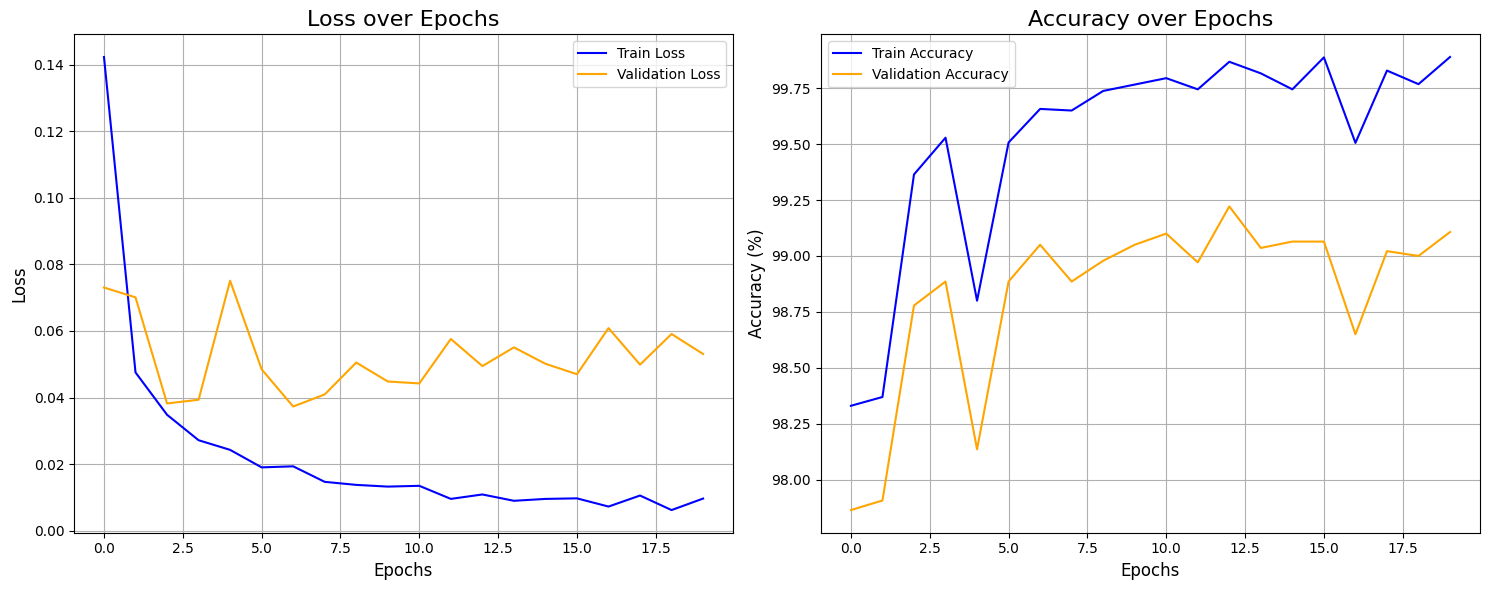

In [ ]:
plot_history(history)

In [ ]:
_, mnist_test_accuracy = evaluate(best_classifier_model, source_test_loader, criterion, device)
print(f"Final Accuracy on MNIST Test Set: {mnist_test_accuracy:.2f}%")

_, mnist_m_accuracy = evaluate(best_classifier_model, target_full_loader, criterion, device)
print(f"Final Accuracy on Full MNIST-M Set (shows domain shift): {mnist_m_accuracy:.2f}%")

Final Accuracy on MNIST Test Set: 99.22%
Final Accuracy on Full MNIST-M Set (shows domain shift): 61.19%


## Implementing model architecture

In [4]:
class ResidualBlock(nn.Module):

    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(64)

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        return out

In [5]:
class GaussianNoise(nn.Module):

    def __init__(self, stddev=0.2):
        super().__init__()
        self.stddev = stddev

    def forward(self, x):
        if self.training:
            noise = torch.randn_like(x) * self.stddev
            return x + noise
        return x

In [6]:
class Generator(nn.Module):

    def __init__(self, noise_dim=10, img_size=32):
        super(Generator, self).__init__()
        self.img_size = img_size

        self.noise_fc = nn.Linear(noise_dim, img_size * img_size)


        self.initial_conv = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=True)
        )

        res_blocks = [ResidualBlock(in_channels=64) for _ in range(6)]
        self.residual_part = nn.Sequential(*res_blocks)

        self.final_conv = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=3, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x, z):
        noise_channel = self.noise_fc(z).view(z.size(0), 1, self.img_size, self.img_size)
        x_with_noise = torch.cat((x, noise_channel), dim=1)
        out = self.initial_conv(x_with_noise)
        out = self.residual_part(out)
        out = self.final_conv(out)
        return out

In [7]:
class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()
        dropout_p = 0.1

        def d_block(in_filters, out_filters, stride):
            layers = [nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=stride, padding=1)]
            layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Dropout(dropout_p))
            layers.append(GaussianNoise(stddev=0.2))
            return layers

        self.model = nn.Sequential(
            *d_block(3, 64, stride=1),
            *d_block(64, 128, stride=2),
            *d_block(128, 256, stride=2),
            *d_block(256, 512, stride=2)
        )

        self.final_fc = nn.Sequential(
            nn.Linear(512 * 4 * 4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.model(x)
        out = out.view(out.size(0), -1)
        out = self.final_fc(out)
        return out

In [12]:
generator = Generator().to(device)
summary(generator, input_size=[(BATCH_SIZE, 3, 32, 32), (BATCH_SIZE, 10)])

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [32, 3, 32, 32]           --
├─Linear: 1-1                            [32, 1024]                11,264
├─Sequential: 1-2                        [32, 64, 32, 32]          --
│    └─Conv2d: 2-1                       [32, 64, 32, 32]          2,304
│    └─ReLU: 2-2                         [32, 64, 32, 32]          --
├─Sequential: 1-3                        [32, 64, 32, 32]          --
│    └─ResidualBlock: 2-3                [32, 64, 32, 32]          --
│    │    └─Conv2d: 3-1                  [32, 64, 32, 32]          36,864
│    │    └─BatchNorm2d: 3-2             [32, 64, 32, 32]          128
│    │    └─ReLU: 3-3                    [32, 64, 32, 32]          --
│    │    └─Conv2d: 3-4                  [32, 64, 32, 32]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 32, 32]          128
│    └─ResidualBlock: 2-4                [32, 64, 32, 32]          -

In [13]:
discriminator = Discriminator().to(device)
summary(discriminator, input_size=(BATCH_SIZE, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [32, 1]                   --
├─Sequential: 1-1                        [32, 512, 4, 4]           --
│    └─Conv2d: 2-1                       [32, 64, 32, 32]          1,792
│    └─BatchNorm2d: 2-2                  [32, 64, 32, 32]          128
│    └─LeakyReLU: 2-3                    [32, 64, 32, 32]          --
│    └─Dropout: 2-4                      [32, 64, 32, 32]          --
│    └─GaussianNoise: 2-5                [32, 64, 32, 32]          --
│    └─Conv2d: 2-6                       [32, 128, 16, 16]         73,856
│    └─BatchNorm2d: 2-7                  [32, 128, 16, 16]         256
│    └─LeakyReLU: 2-8                    [32, 128, 16, 16]         --
│    └─Dropout: 2-9                      [32, 128, 16, 16]         --
│    └─GaussianNoise: 2-10               [32, 128, 16, 16]         --
│    └─Conv2d: 2-11                      [32, 256, 8, 8]           295,168
│

## Implementing loss functions

In [ ]:
loss_weight_D = 0.13
loss_weight_G_adv = 0.011
loss_weight_G_task = 0.01

In [ ]:
adversarial_loss_fn = nn.BCELoss()
task_loss_fn = nn.CrossEntropyLoss()

In [ ]:
def calculate_losses(G, D, T, source_images, source_labels, target_images):

    real_labels = torch.ones(BATCH_SIZE, 1, device=device)
    noise = torch.randn(BATCH_SIZE, 10, device=device)
    fake_images = G(source_images, noise)

    # Step D Losses (D and T)
    real_d_output = D(target_images)
    loss_d_real = adversarial_loss_fn(real_d_output, real_labels)

    fake_d_output = D(fake_images.detach())
    loss_d_fake = adversarial_loss_fn(1 - fake_d_output, real_labels)

    total_loss_D = (loss_d_real + loss_d_fake) * loss_weight_D

    loss_t_source = task_loss_fn(T(source_images), source_labels)
    loss_t_fake = task_loss_fn(T(fake_images.detach()), source_labels)
    total_loss_T = loss_t_source + loss_t_fake

    # Step G Losses (G) ---
    d_output_for_g = D(fake_images)
    loss_g_adv = adversarial_loss_fn(d_output_for_g, real_labels) * loss_weight_G_adv

    t_output_for_g = T(fake_images)
    loss_g_task = task_loss_fn(t_output_for_g, source_labels) * loss_weight_G_task

    total_loss_G = loss_g_adv + loss_g_task

    return total_loss_D, total_loss_T, total_loss_G

## Training model

In [ ]:
def train_pixelda(G, D, T, optimizer_G, optimizer_DT, scheduler_G, scheduler_DT, source_train_loader, target_train_loader, source_test_loader, target_test_loader, num_epochs, device, save_path):
    history = {'gen_loss': [], 'disc_loss': [], 'task_loss': [], 'train_acc': [], 'source_test_acc': [], 'target_test_acc': []}
    best_source_test_acc = 0.0

    adv_loss_fn = nn.BCELoss()
    task_loss_fn = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        G.train(); D.train(); T.train()

        running_g_loss, running_d_loss, running_t_loss = 0.0, 0.0, 0.0

        progress_bar = tqdm(zip(source_train_loader, target_train_loader), total=min(len(source_train_loader), len(target_train_loader)), desc=f"Epoch {epoch+1}/{num_epochs}")

        for (source_images, source_labels), (target_images, _) in progress_bar:
            source_images, source_labels = source_images.to(device), source_labels.to(device)
            target_images = target_images.to(device)

            real_labels = torch.ones(source_images.size(0), 1, device=device)

            # --- Step A: Update Discriminator (D) and Task Classifier (T) ---
            optimizer_DT.zero_grad()

            noise = torch.randn(source_images.size(0), NOISE_DIM, device=device)
            fake_images = G(source_images, noise).detach()

            loss_d_real = adv_loss_fn(D(target_images), real_labels)
            loss_d_fake = adv_loss_fn(1 - D(fake_images), real_labels)
            total_loss_D = (loss_d_real + loss_d_fake) * loss_weight_D

            loss_t_source = task_loss_fn(T(source_images), source_labels)
            loss_t_fake = task_loss_fn(T(fake_images), source_labels)
            total_loss_T = loss_t_source + loss_t_fake

            loss_for_dt = total_loss_D + total_loss_T
            loss_for_dt.backward()
            optimizer_DT.step()
            scheduler_DT.step()

            # --- Step B: Update Generator (G) ---
            optimizer_G.zero_grad()

            fake_images = G(source_images, noise)

            loss_g_adv = adv_loss_fn(D(fake_images), real_labels) * loss_weight_G_adv
            loss_g_task = task_loss_fn(T(fake_images), source_labels) * loss_weight_G_task

            total_loss_G = loss_g_adv + loss_g_task

            total_loss_G.backward()
            optimizer_G.step()
            scheduler_G.step()

            running_g_loss += total_loss_G.item()
            running_d_loss += total_loss_D.item()
            running_t_loss += total_loss_T.item()
            progress_bar.set_postfix(G_loss=f"{total_loss_G.item():.4f}", D_loss=f"{total_loss_D.item():.4f}", T_loss=f"{total_loss_T.item():.4f}")

        avg_g_loss = running_g_loss / len(source_train_loader)
        avg_d_loss = running_d_loss / len(source_train_loader)
        avg_t_loss = running_t_loss / len(source_train_loader)

        T.eval()
        with torch.no_grad():
            _, train_acc = evaluate(T, source_train_loader, task_loss_fn, device)
            _, source_test_acc = evaluate(T, source_test_loader, task_loss_fn, device)
            _, target_test_acc = evaluate(T, target_test_loader, task_loss_fn, device)

        history['gen_loss'].append(avg_g_loss)
        history['disc_loss'].append(avg_d_loss)
        history['task_loss'].append(avg_t_loss)
        history['train_acc'].append(train_acc)
        history['source_test_acc'].append(source_test_acc)
        history['target_test_acc'].append(target_test_acc)

        print(f"Epoch {epoch+1} Summary | G Loss: {avg_g_loss:.4f} | D Loss: {avg_d_loss:.4f} | T Loss: {avg_t_loss:.4f} | Train Acc: {train_acc:.2f}% | Source Test Acc: {source_test_acc:.2f}% | Target Test Acc: {target_test_acc:.2f}%")

        if source_test_acc > best_source_test_acc:
            best_source_test_acc = source_test_acc
            torch.save(G.state_dict(), os.path.join(save_path, "best_generator.pth"))
            torch.save(D.state_dict(), os.path.join(save_path, "best_discriminator.pth"))
            torch.save(T.state_dict(), os.path.join(save_path, "best_task_classifier.pth"))
            with open(os.path.join(save_path, 'history.json'), 'w') as f:
                json.dump(history, f)

    G.load_state_dict(torch.load(os.path.join(save_path, "best_generator.pth")))
    D.load_state_dict(torch.load(os.path.join(save_path, "best_discriminator.pth")))
    T.load_state_dict(torch.load(os.path.join(save_path, "best_task_classifier.pth")))

    return G, D, T, history

In [ ]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return total_loss / total, (correct / total) * 100

In [ ]:
def plot_gan_history(history):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))
    fig.suptitle('PixelDA Training History', fontsize=16)


    ax1.plot(history['gen_loss'], label='Generator Loss', color='g')
    ax1.plot(history['disc_loss'], label='Discriminator Loss', color='r')
    ax1.set_title('Adversarial Losses (Generator vs. Discriminator)')
    ax1.set_xlabel('Epochs'); ax1.set_ylabel('Loss')
    ax1.legend(); ax1.grid(True)

    ax2.plot(history['gen_loss'], label='Generator Loss', color='g')
    ax2.plot(history['disc_loss'], label='Discriminator Loss', color='r')
    ax2.plot(history['task_loss'], label='Task Classifier Loss', color='b')
    ax2.set_title('Losses over Epochs')
    ax2.set_xlabel('Epochs'); ax2.set_ylabel('Loss')
    ax2.legend(); ax2.grid(True)

    ax3.plot(history['train_acc'], label='Train Accuracy (Source)', color='c')
    ax3.plot(history['source_test_acc'], label='Test Accuracy (Source)', color='m')
    ax3.plot(history['target_test_acc'], label='Test Accuracy (Target)', color='y', linestyle='--')
    ax3.set_title('Classifier Accuracy over Epochs')
    ax3.set_xlabel('Epochs'); ax3.set_ylabel('Accuracy (%)')
    ax3.legend(); ax3.grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [ ]:
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
ADAM_BETA1 = 0.5
NUM_EPOCHS = 20
NOISE_DIM = 10
LR_DECAY_STEP = 20000
LR_DECAY_GAMMA = 0.95
SAVE_PATH = os.path.join(base_path, "pixelda_results")

In [ ]:
G = Generator().to(device); G.apply(init_weights)
D = Discriminator().to(device); D.apply(init_weights)
T = TaskClassifier().to(device); T.apply(init_weights)

optimizer_G = optim.Adam(G.parameters(), lr=LEARNING_RATE, betas=(ADAM_BETA1, 0.999), weight_decay=WEIGHT_DECAY)
optimizer_DT = optim.Adam(list(D.parameters()) + list(T.parameters()), lr=LEARNING_RATE, betas=(ADAM_BETA1, 0.999), weight_decay=WEIGHT_DECAY)

scheduler_G = optim.lr_scheduler.StepLR(optimizer_G, step_size=LR_DECAY_STEP, gamma=LR_DECAY_GAMMA)
scheduler_DT = optim.lr_scheduler.StepLR(optimizer_DT, step_size=LR_DECAY_STEP, gamma=LR_DECAY_GAMMA)

In [ ]:
best_G, best_D, best_T, history = train_pixelda(
    G, D, T, optimizer_G, optimizer_DT,
    scheduler_G, scheduler_DT,
    source_train_loader, target_train_loader, source_test_loader, target_test_loader,
    num_epochs=NUM_EPOCHS, device=device, save_path=SAVE_PATH
)

Epoch 1/20: 100%|██████████| 1750/1750 [02:06<00:00, 13.84it/s, D_loss=0.3723, G_loss=0.1124, T_loss=0.1183]


Epoch 1 Summary | G Loss: 0.0491 | D Loss: 0.1048 | T Loss: 0.5866 | Train Acc: 98.17% | Source Test Acc: 97.74% | Target Test Acc: 87.23%


Epoch 2/20: 100%|██████████| 1750/1750 [02:08<00:00, 13.63it/s, D_loss=0.1679, G_loss=0.0933, T_loss=0.0960]


Epoch 2 Summary | G Loss: 0.0521 | D Loss: 0.0827 | T Loss: 0.1846 | Train Acc: 98.70% | Source Test Acc: 98.34% | Target Test Acc: 90.51%


Epoch 3/20: 100%|██████████| 1750/1750 [02:07<00:00, 13.77it/s, D_loss=0.0473, G_loss=0.0941, T_loss=0.0478]


Epoch 3 Summary | G Loss: 0.0631 | D Loss: 0.0638 | T Loss: 0.1564 | Train Acc: 99.14% | Source Test Acc: 98.72% | Target Test Acc: 92.36%


Epoch 4/20: 100%|██████████| 1750/1750 [02:07<00:00, 13.76it/s, D_loss=0.0444, G_loss=0.0917, T_loss=0.0600]


Epoch 4 Summary | G Loss: 0.0656 | D Loss: 0.0590 | T Loss: 0.1459 | Train Acc: 99.31% | Source Test Acc: 98.65% | Target Test Acc: 93.26%


Epoch 5/20: 100%|██████████| 1750/1750 [02:06<00:00, 13.81it/s, D_loss=0.0304, G_loss=0.0290, T_loss=0.1060]


Epoch 5 Summary | G Loss: 0.0606 | D Loss: 0.0665 | T Loss: 0.1126 | Train Acc: 99.39% | Source Test Acc: 98.64% | Target Test Acc: 93.47%


Epoch 6/20: 100%|██████████| 1750/1750 [02:06<00:00, 13.78it/s, D_loss=0.0303, G_loss=0.0681, T_loss=0.0475]


Epoch 6 Summary | G Loss: 0.0630 | D Loss: 0.0598 | T Loss: 0.1082 | Train Acc: 99.59% | Source Test Acc: 98.72% | Target Test Acc: 94.29%


Epoch 7/20: 100%|██████████| 1750/1750 [02:06<00:00, 13.86it/s, D_loss=0.0617, G_loss=0.0471, T_loss=0.2240]


Epoch 7 Summary | G Loss: 0.0603 | D Loss: 0.0656 | T Loss: 0.0960 | Train Acc: 99.55% | Source Test Acc: 98.85% | Target Test Acc: 95.22%


Epoch 8/20: 100%|██████████| 1750/1750 [02:07<00:00, 13.77it/s, D_loss=0.0112, G_loss=0.0346, T_loss=0.0127]


Epoch 8 Summary | G Loss: 0.0632 | D Loss: 0.0540 | T Loss: 0.1015 | Train Acc: 99.48% | Source Test Acc: 98.82% | Target Test Acc: 93.84%


Epoch 9/20: 100%|██████████| 1750/1750 [02:06<00:00, 13.80it/s, D_loss=0.0084, G_loss=0.0732, T_loss=0.0010]


Epoch 9 Summary | G Loss: 0.0642 | D Loss: 0.0581 | T Loss: 0.0989 | Train Acc: 99.47% | Source Test Acc: 98.79% | Target Test Acc: 94.91%


Epoch 10/20: 100%|██████████| 1750/1750 [02:07<00:00, 13.71it/s, D_loss=0.0277, G_loss=0.0613, T_loss=0.0175]


Epoch 10 Summary | G Loss: 0.0605 | D Loss: 0.0660 | T Loss: 0.0908 | Train Acc: 99.68% | Source Test Acc: 98.82% | Target Test Acc: 95.77%


Epoch 11/20: 100%|██████████| 1750/1750 [02:07<00:00, 13.73it/s, D_loss=0.0098, G_loss=0.0523, T_loss=0.2723]


Epoch 11 Summary | G Loss: 0.0651 | D Loss: 0.0539 | T Loss: 0.0959 | Train Acc: 99.68% | Source Test Acc: 98.89% | Target Test Acc: 95.83%


Epoch 12/20: 100%|██████████| 1750/1750 [02:07<00:00, 13.73it/s, D_loss=0.0154, G_loss=0.0638, T_loss=0.2397]


Epoch 12 Summary | G Loss: 0.0606 | D Loss: 0.0625 | T Loss: 0.0859 | Train Acc: 99.78% | Source Test Acc: 98.88% | Target Test Acc: 95.84%


Epoch 13/20: 100%|██████████| 1750/1750 [02:07<00:00, 13.75it/s, D_loss=0.0204, G_loss=0.0445, T_loss=0.0344]


Epoch 13 Summary | G Loss: 0.0618 | D Loss: 0.0576 | T Loss: 0.0858 | Train Acc: 99.75% | Source Test Acc: 98.92% | Target Test Acc: 96.40%


Epoch 14/20: 100%|██████████| 1750/1750 [02:06<00:00, 13.79it/s, D_loss=0.0353, G_loss=0.0743, T_loss=0.0158]


Epoch 14 Summary | G Loss: 0.0627 | D Loss: 0.0581 | T Loss: 0.0812 | Train Acc: 99.56% | Source Test Acc: 98.67% | Target Test Acc: 95.65%


Epoch 15/20: 100%|██████████| 1750/1750 [02:06<00:00, 13.80it/s, D_loss=0.0078, G_loss=0.0730, T_loss=0.0345]


Epoch 15 Summary | G Loss: 0.0597 | D Loss: 0.0662 | T Loss: 0.0785 | Train Acc: 99.86% | Source Test Acc: 99.09% | Target Test Acc: 96.36%


Epoch 16/20: 100%|██████████| 1750/1750 [02:08<00:00, 13.65it/s, D_loss=0.0073, G_loss=0.0787, T_loss=0.0911]


Epoch 16 Summary | G Loss: 0.0571 | D Loss: 0.0668 | T Loss: 0.0741 | Train Acc: 99.80% | Source Test Acc: 99.06% | Target Test Acc: 96.29%


Epoch 17/20: 100%|██████████| 1750/1750 [02:07<00:00, 13.72it/s, D_loss=0.1504, G_loss=0.0450, T_loss=0.0999]


Epoch 17 Summary | G Loss: 0.0586 | D Loss: 0.0616 | T Loss: 0.0713 | Train Acc: 99.73% | Source Test Acc: 98.91% | Target Test Acc: 96.14%


Epoch 18/20: 100%|██████████| 1750/1750 [02:07<00:00, 13.75it/s, D_loss=0.1794, G_loss=0.0659, T_loss=0.0323]


Epoch 18 Summary | G Loss: 0.0573 | D Loss: 0.0644 | T Loss: 0.0743 | Train Acc: 99.84% | Source Test Acc: 99.01% | Target Test Acc: 96.34%


Epoch 19/20: 100%|██████████| 1750/1750 [02:07<00:00, 13.73it/s, D_loss=0.1471, G_loss=0.0270, T_loss=0.0654]


Epoch 19 Summary | G Loss: 0.0610 | D Loss: 0.0602 | T Loss: 0.0840 | Train Acc: 99.86% | Source Test Acc: 99.09% | Target Test Acc: 96.61%


Epoch 20/20: 100%|██████████| 1750/1750 [02:06<00:00, 13.83it/s, D_loss=0.0191, G_loss=0.0671, T_loss=0.0101]


Epoch 20 Summary | G Loss: 0.0587 | D Loss: 0.0633 | T Loss: 0.0651 | Train Acc: 99.72% | Source Test Acc: 98.86% | Target Test Acc: 96.61%


## Show the results

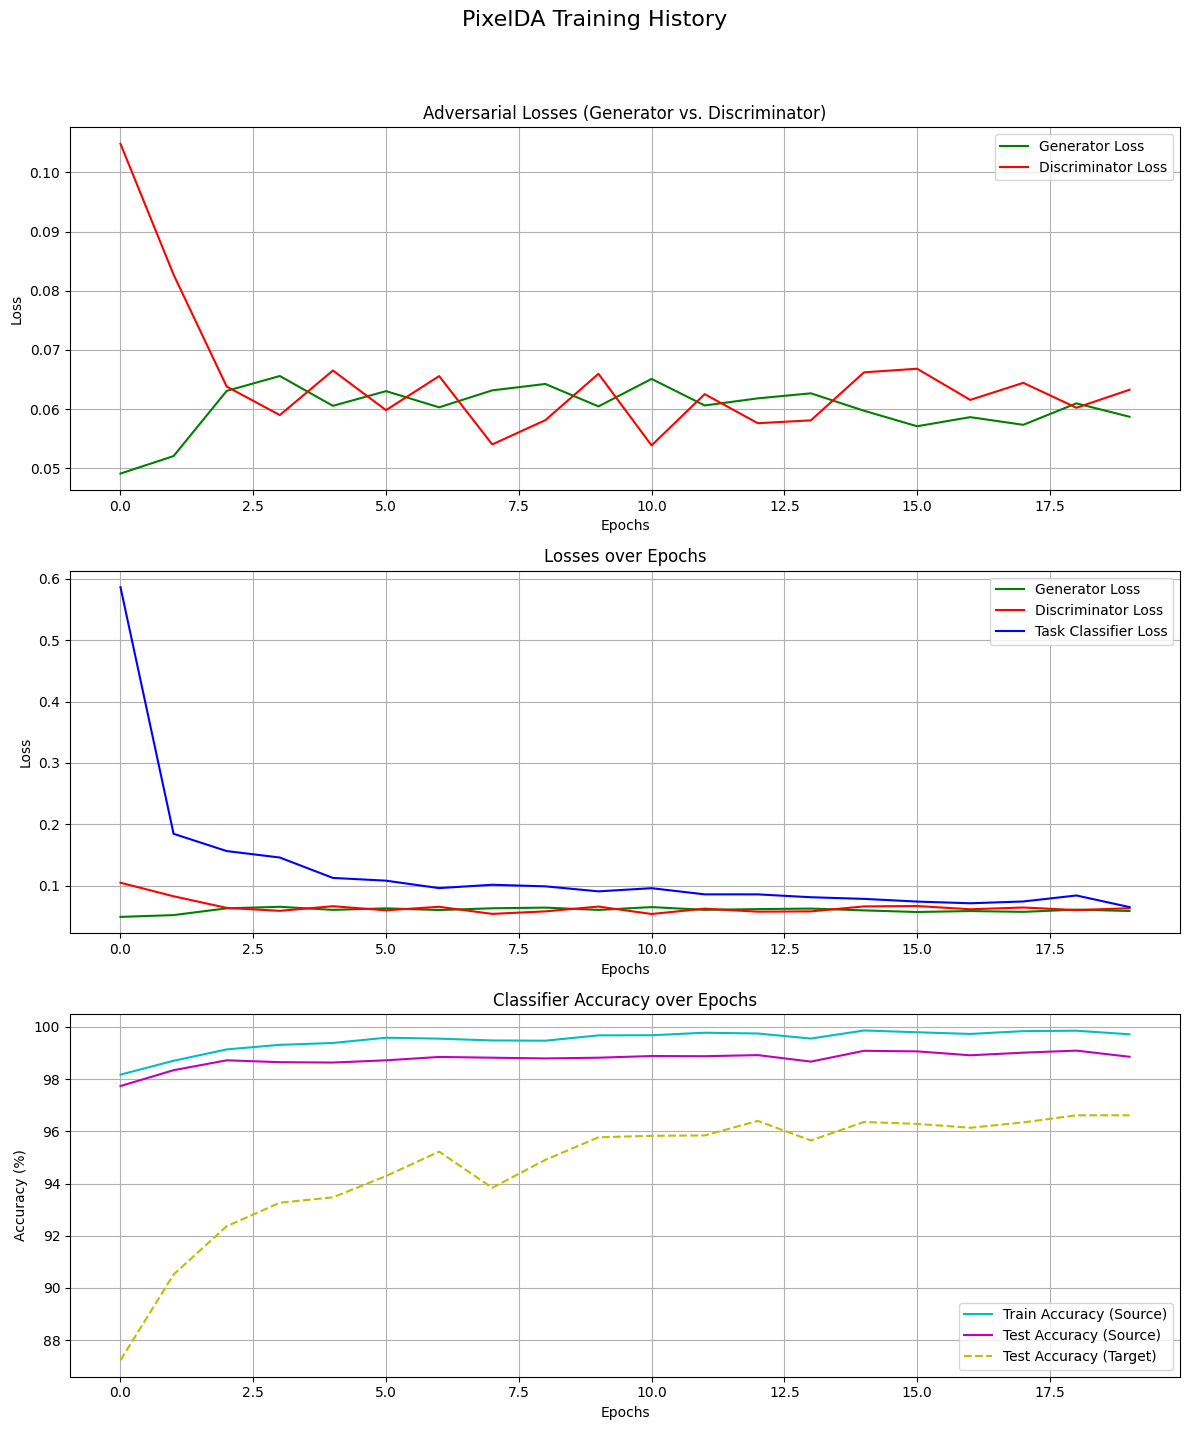

In [ ]:
plot_gan_history(history)

In [ ]:
_, source_test_acc = evaluate(best_T, source_test_loader, criterion, device)
print(f"Final Accuracy on Source Test Set (MNIST): {source_test_acc:.2f}%")

_, target_test_acc = evaluate(best_T, target_test_loader, criterion, device)
print(f"Final Accuracy on Target Test Set (MNIST-M): {target_test_acc:.2f}%")

_, target_total_acc = evaluate(best_T, target_full_loader, criterion, device)
print(f"Final Accuracy on Full MNIST-M Set: {target_total_acc:.2f}%")

Final Accuracy on Source Test Set (MNIST): 99.09%
Final Accuracy on Target Test Set (MNIST-M): 96.61%
Final Accuracy on Full MNIST-M Set: 97.35%


In [ ]:
def visualize_results(G, T, source_loader, target_loader, device, num_images=5):
    G.eval()
    T.eval()

    source_batch, target_batch = next(iter(zip(source_loader, target_loader)))
    source_images, source_labels = source_batch
    target_images, _ = target_batch

    indices = random.sample(range(len(source_images)), num_images)

    fig, axes = plt.subplots(3, num_images, figsize=(15, 11))
    fig.suptitle('PixelDA Results: Source -> Generated -> Target', fontsize=16)

    for i, idx in enumerate(indices):
        source_img = source_images[idx].unsqueeze(0).to(device)
        target_img = target_images[idx].unsqueeze(0).to(device)
        true_label = source_labels[idx].item()

        with torch.no_grad():
            # Row 1: Source
            source_pred = T(source_img).argmax(1).item()

            # Row 2: Generated
            noise = torch.randn(1, NOISE_DIM, device=device)
            generated_img = G(source_img, noise)
            generated_pred = T(generated_img).argmax(1).item()

            # Row 3: Target
            target_pred = T(target_img).argmax(1).item()

        def denorm(img_tensor):
            img = img_tensor.div(2).add(0.5).clamp(0, 1)
            return img.squeeze().permute(1, 2, 0).cpu().numpy()

        axes[0, i].imshow(denorm(source_img))
        axes[0, i].set_title(f"Source (MNIST)\nReal: {true_label}, Pred: {source_pred}", color=("green" if true_label==source_pred else "red"))
        axes[0, i].axis('off')

        axes[1, i].imshow(denorm(generated_img))
        axes[1, i].set_title(f"Generated\nReal: {true_label}, Pred: {generated_pred}", color=("green" if true_label==generated_pred else "red"))
        axes[1, i].axis('off')

        axes[2, i].imshow(denorm(target_img))
        axes[2, i].set_title(f"Target (MNIST-M)\nReal: {true_label}, Pred: {target_pred}", color=("green" if true_label==target_pred else "red"))
        axes[2, i].axis('off')

    fig.tight_layout(pad=3.0, rect=[0, 0, 1, 0.95])
    plt.show()

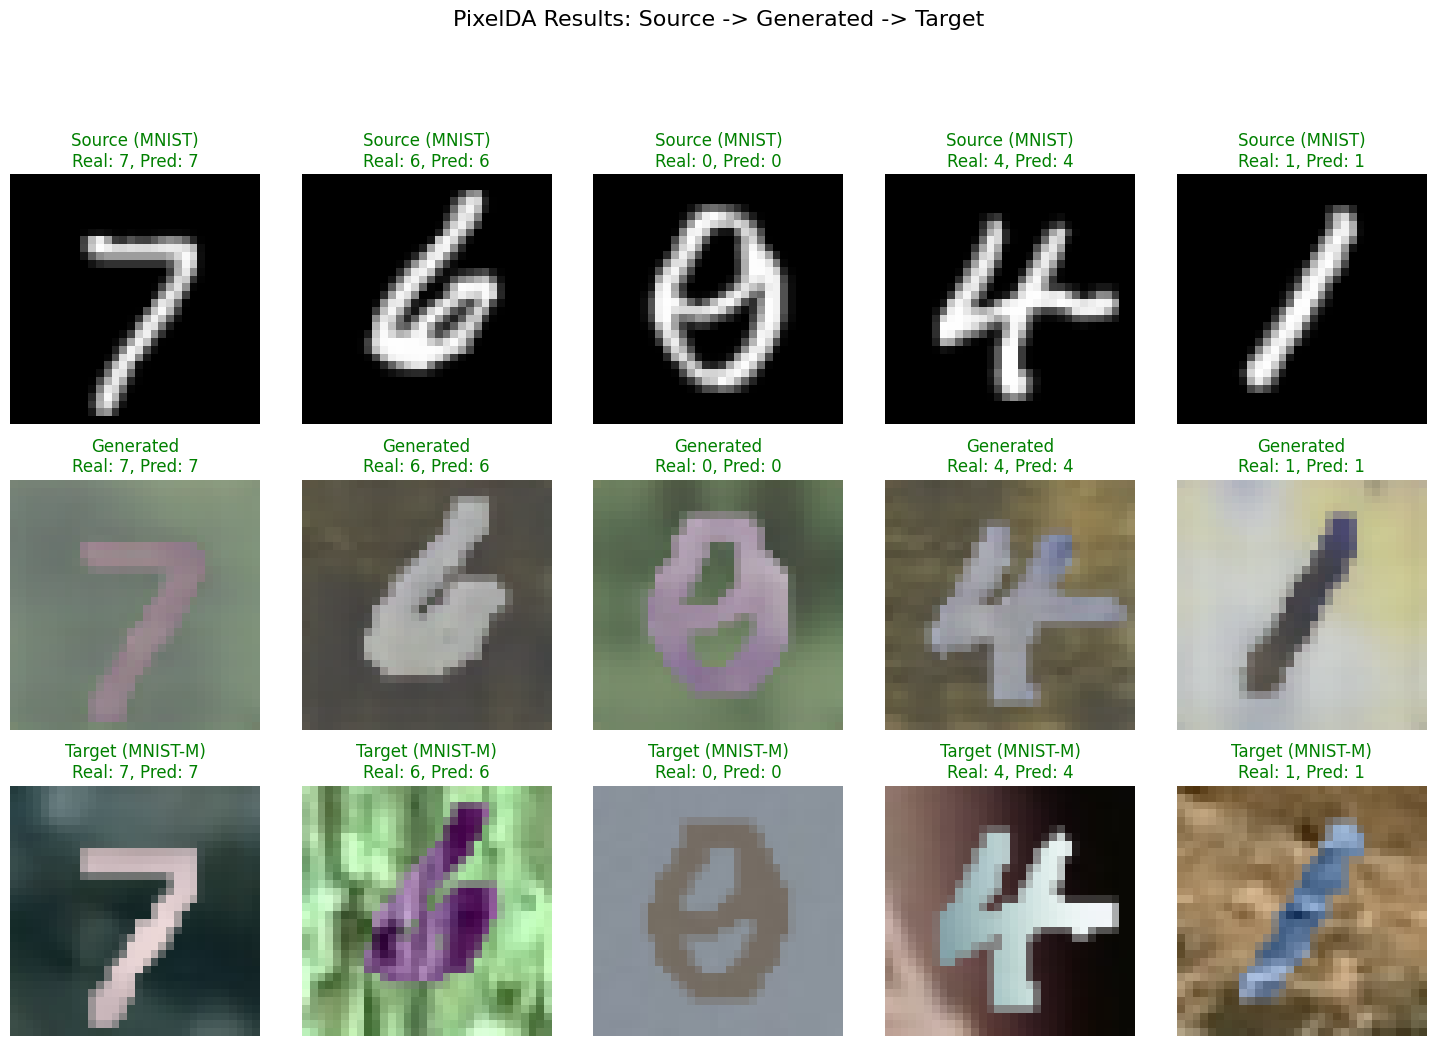

In [ ]:
visualize_results(best_G, best_T, source_test_loader, target_test_loader, device)